In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Define the skewed Bernoulli map and its derivative
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1/b, b, b / (b - 1))


In [ ]:
def evolve_system(y, v, epsilon, b):
    N = len(y)
    y_mean = np.mean(y)
    input_y = (1 - epsilon) * y + epsilon * y_mean
    y_next = f_SB(input_y, b)

    v_mean = np.mean(v)
    input_v = (1 - epsilon) * v + epsilon * v_mean
    f_prime = df_SB(input_y, b)
    v_next = f_prime * input_v

    return y_next, v_next

def compute_lyapunov(N, b=4.0, epsilon=0.02, T_trans=2000, T_lyap=10000):
    y = np.random.rand(N).astype(np.float64)
    v = np.random.rand(N).astype(np.float64)
    v /= np.linalg.norm(v)

    # Burn-in period
    for _ in range(T_trans):
        y, v = evolve_system(y, v, epsilon, b)
        v /= np.linalg.norm(v)

    le_sum = 0.0
    for _ in range(T_lyap):
        y, v = evolve_system(y, v, epsilon, b)
        norm_v = np.linalg.norm(v)
        le_sum += np.log(norm_v)
        v /= norm_v

    return le_sum / T_lyap


In [ ]:
def compute_lyapunov_avg(args):
    N, b, epsilon, T_trans, T_lyap, trials = args
    return np.mean([
        compute_lyapunov(N, b, epsilon, T_trans, T_lyap)
        for _ in range(trials)
    ])


In [ ]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot


In [ ]:
def simulate_and_plot(N_list, b=4.0, epsilon=0.02, trials=5, T_trans=2000, T_lyap=10000):
    args = [(N, b, epsilon, T_trans, T_lyap, trials) for N in N_list]

    with Pool() as pool:
        lambda_list = pool.map(compute_lyapunov_avg, args)

    lambda_array = np.array(lambda_list)
    lambda_inf = np.mean(lambda_array[-3:])  # average of largest 3 N

    # ----- Plot 1: λ(N) vs 1 / ln(N) -----
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    x1 = 1 / np.log(N_list)
    y1 = lambda_array
    coeffs1 = np.polyfit(x1, y1, 1)
    y1_fit = np.polyval(coeffs1, x1)
    r2_1 = r2_score(y1, y1_fit)
    plt.plot(x1, y1, 'bo', label='Data')
    plt.plot(x1, y1_fit, 'g--', label='Fit')
    plt.xlabel('1 / ln(N)')
    plt.ylabel('λ(N)')
    plt.title(f'Logarithmic Fit\n$R^2$ = {r2_1:.4f}')
    plt.legend()

    # ----- Plot 2: ln(λ∞ - λ(N)) vs ln(N) -----
    plt.subplot(1, 2, 2)
    x2 = np.log(N_list)
    delta = np.abs(lambda_inf - lambda_array) + 1e-12
    y2 = np.log(delta)
    coeffs2 = np.polyfit(x2, y2, 1)
    y2_fit = np.polyval(coeffs2, x2)
    r2_2 = r2_score(y2, y2_fit)
    gamma = -coeffs2[0]
    plt.plot(x2, y2, 'bo', label='Data')
    plt.plot(x2, y2_fit, 'g--', label='Fit')
    plt.xlabel('ln(N)')
    plt.ylabel('ln(λ∞ - λ(N))')
    plt.title(f'Power-law Fit, γ ≈ {gamma:.2f}\n$R^2$ = {r2_2:.4f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return lambda_array, gamma, r2_1, r2_2


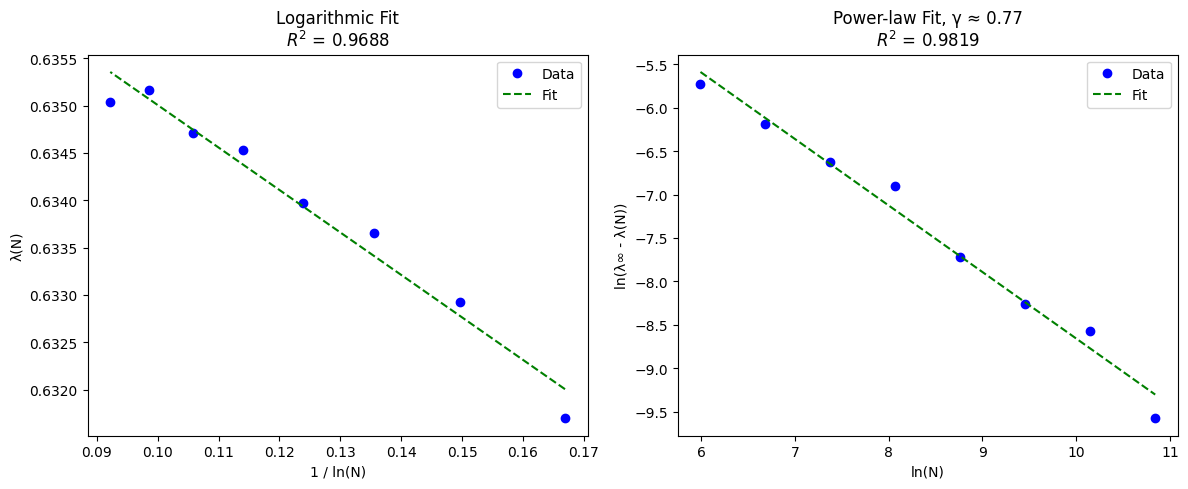

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list)


In [ ]:
def sweep_epsilon(N_list, epsilon_list, b=4.0, trials=5, T_trans=2000, T_lyap=10000):
    lambda_inf_list = []
    gamma_list = []

    for epsilon in epsilon_list:
        print(f"Running for epsilon = {epsilon:.3f}")
        args = [(N, b, epsilon, T_trans, T_lyap, trials) for N in N_list]

        with Pool() as pool:
            lambda_list = pool.map(compute_lyapunov_avg, args)

        lambda_array = np.array(lambda_list)
        lambda_inf = np.mean(lambda_array[-3:])
        delta = np.abs(lambda_inf - lambda_array) + 1e-12
        x2 = np.log(N_list)
        y2 = np.log(delta)
        coeffs = np.polyfit(x2, y2, 1)
        gamma = -coeffs[0]

        lambda_inf_list.append(lambda_inf)
        gamma_list.append(gamma)

    return np.array(lambda_inf_list), np.array(gamma_list)

In [8]:


# Define your parameters
N_list = [400, 800, 1600, 3200, 6400, 12800]
epsilon_list = np.linspace(0, 1, 20)  # 25 points from 0 to 1

# Run the sweep
lambda_inf_vals, gamma_vals = sweep_epsilon(N_list, epsilon_list)

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilon_list, lambda_inf_vals, 'o-', color='blue')
plt.xlabel("ε")
plt.ylabel("λ∞(ε)")
plt.title("Asymptotic Lyapunov Exponent vs ε")

plt.subplot(1, 2, 2)
plt.plot(epsilon_list, gamma_vals, 'o-', color='red')
plt.xlabel("ε")
plt.ylabel("γ(ε)")
plt.title("Convergence Exponent γ vs ε")

plt.tight_layout()
plt.show()


Running for epsilon = 0.000
Running for epsilon = 0.053
Running for epsilon = 0.105
Running for epsilon = 0.158
Running for epsilon = 0.211
Running for epsilon = 0.263
Running for epsilon = 0.316
Running for epsilon = 0.368
Running for epsilon = 0.421
Running for epsilon = 0.474


KeyboardInterrupt: 

In [ ]:
print(lambda_inf_vals)
print(gamma_vals)

[0.57360816 0.63430397 0.61378111 0.60363006 0.60220917 0.60332167
 0.61369282 0.60177173 0.58658046 0.58716795 0.59132646 0.5935018
 0.59171478 0.5728116  0.56813573 0.56796367 0.58494347 0.58720815
 0.6036705  0.58728993 0.58396433 0.57964941 0.56319206 0.56108273
 0.56175654 0.56199091 0.5611047  0.56434927 0.5614709  0.56069455
 0.5608923  0.56368278 0.5601306  0.56132442 0.56210077 0.56474477
 0.56400504 0.56051877 0.56147823 0.5626867  0.56245233 0.56243036
 0.56144893 0.56396109 0.5624743  0.56435659 0.56451772 0.56323601
 0.5645104  0.56185176]
[ 0.1561278   0.85543984  0.67598875  0.2839471   0.90726803  0.58612695
  0.98523453  0.97002189  0.52742511 -0.04944867  0.56303147  0.57998479
  0.86800804  0.86612759  1.2094072   1.23252099  0.92125119  1.04157977
  1.06918963  0.71873986  0.14090461  0.05559946  0.24573841 -0.34329877
 -0.3324692   0.1865632   0.48493616  0.46448465  0.53246003 -0.13392544
  0.1598535   0.22440979  0.85430978  0.1255537  -0.11755904  0.13992966
  0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the skewed Bernoulli map
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

# Simulate and store y_i(t) for all oscillators
def simulate_y_trajectories(N=100, T=1000, epsilon=0.3, b=4.0):
    y = np.random.rand(N)
    y_history = np.zeros((T, N))

    for t in range(T):
        y_mean = np.mean(y)
        input_y = (1 - epsilon) * y + epsilon * y_mean
        y = f_SB(input_y, b)
        y_history[t] = y

    return y_history

# Plot selected trajectories y_i(t)
def plot_y_trajectories_lines(y_history, epsilon, num_to_plot=10):
    T, N = y_history.shape
    indices = np.linspace(0, N-1, num_to_plot, dtype=int)

    plt.figure(figsize=(12, 6))
    for i in indices:
        plt.plot(range(T), y_history[:, i], label=f'Oscillator {i}')
    plt.xlabel("Time step")
    plt.ylabel("y_i(t)")
    plt.title(f'Trajectories of {num_to_plot} Oscillators for ε = {epsilon}')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()


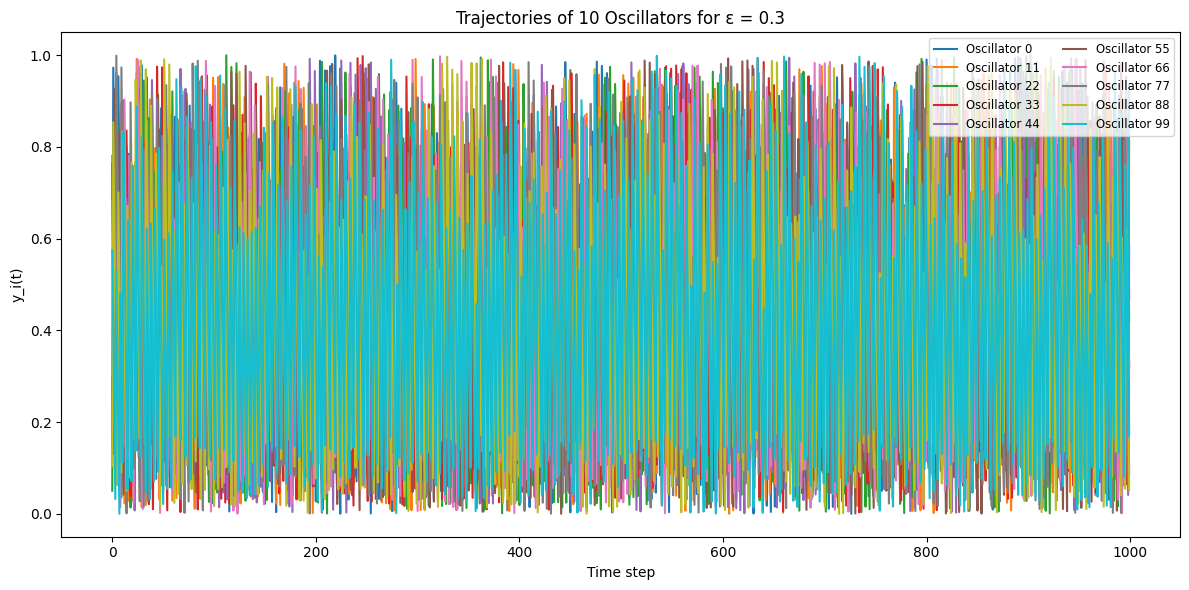

In [ ]:
epsilon = 0.3  # Try 0.05, 0.15, 0.25, 0.6, etc.
y_hist = simulate_y_trajectories(N=100, T=1000, epsilon=epsilon, b=4.0)
plot_y_trajectories_lines(y_hist, epsilon, num_to_plot=10)


Simulating for ε = 0.02


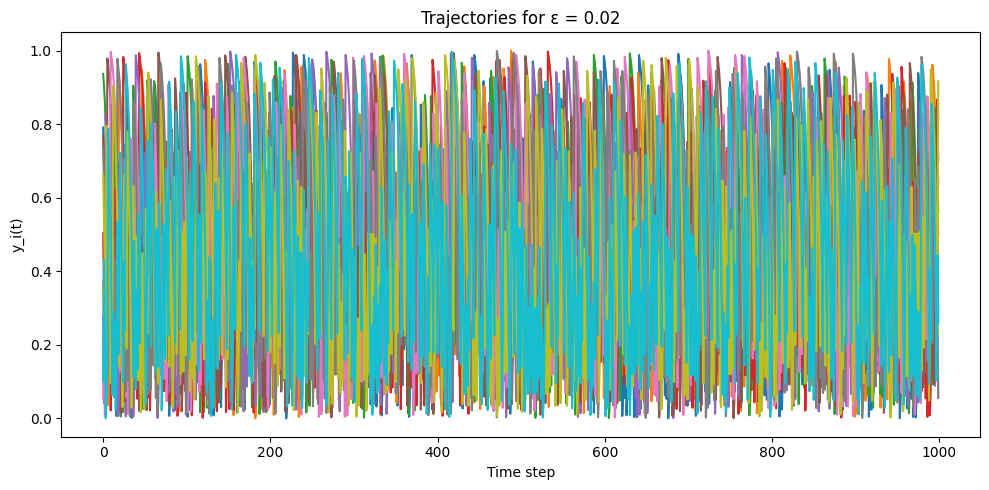

Simulating for ε = 0.08


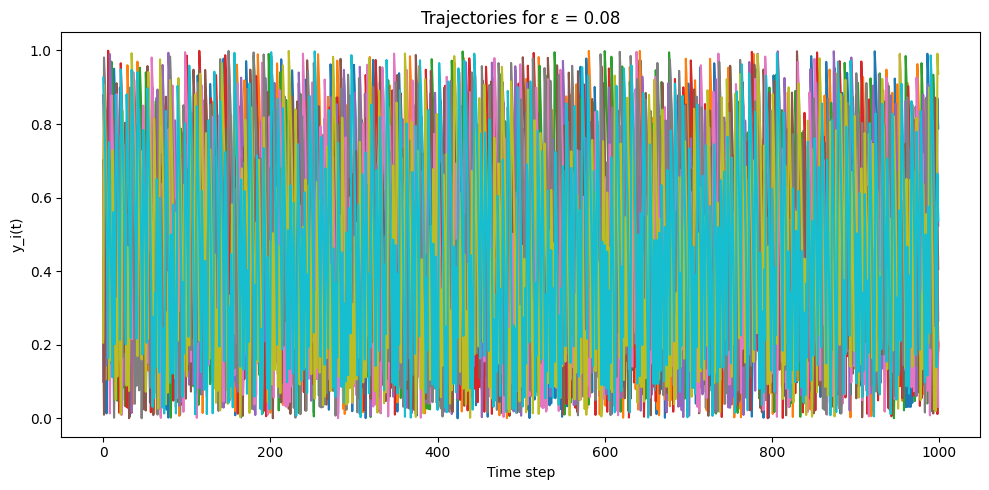

Simulating for ε = 0.15


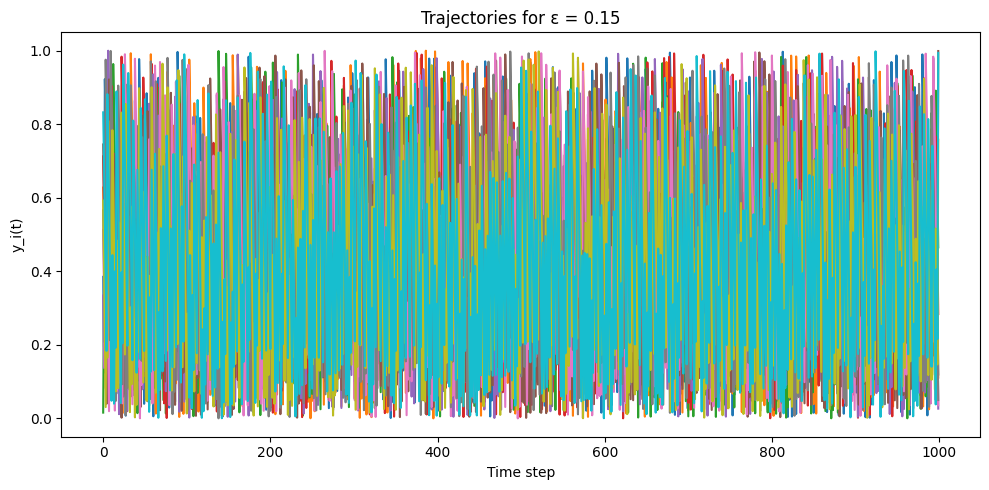

Simulating for ε = 0.25


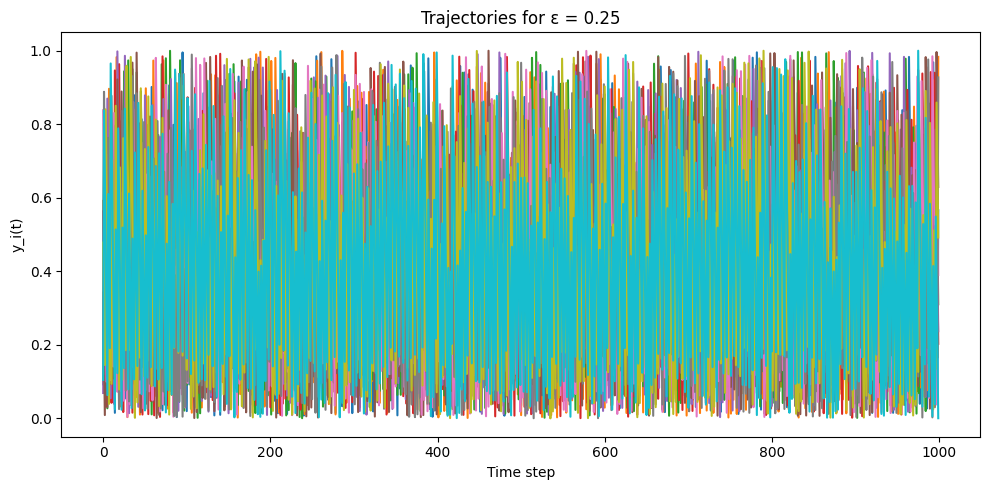

Simulating for ε = 0.4


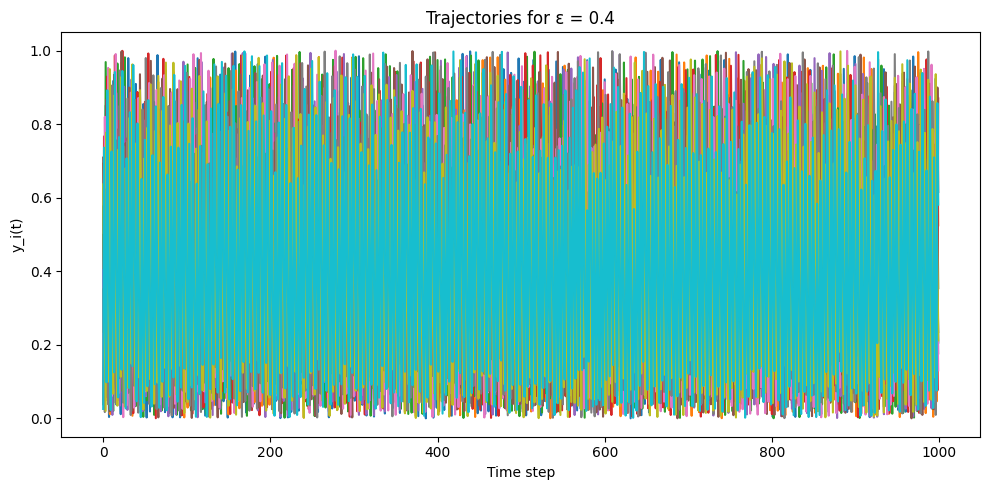

Simulating for ε = 0.6


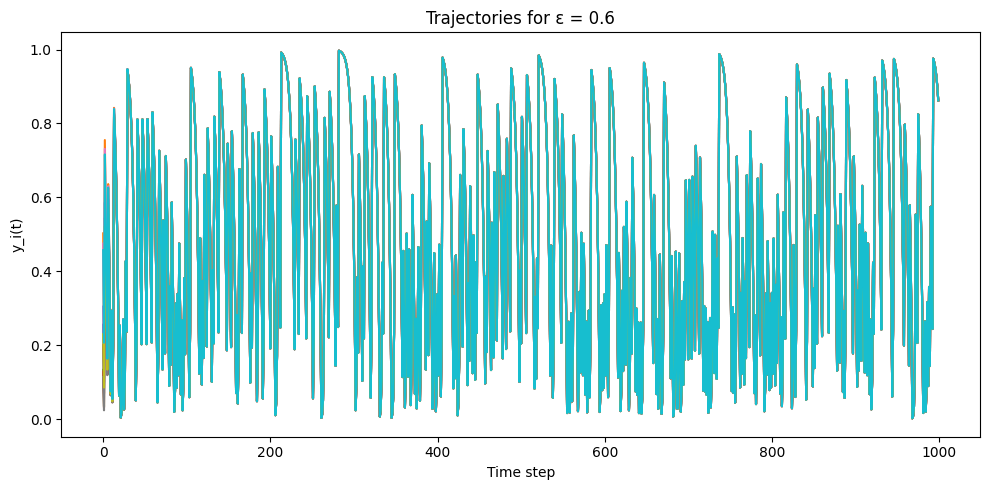

Simulating for ε = 0.8


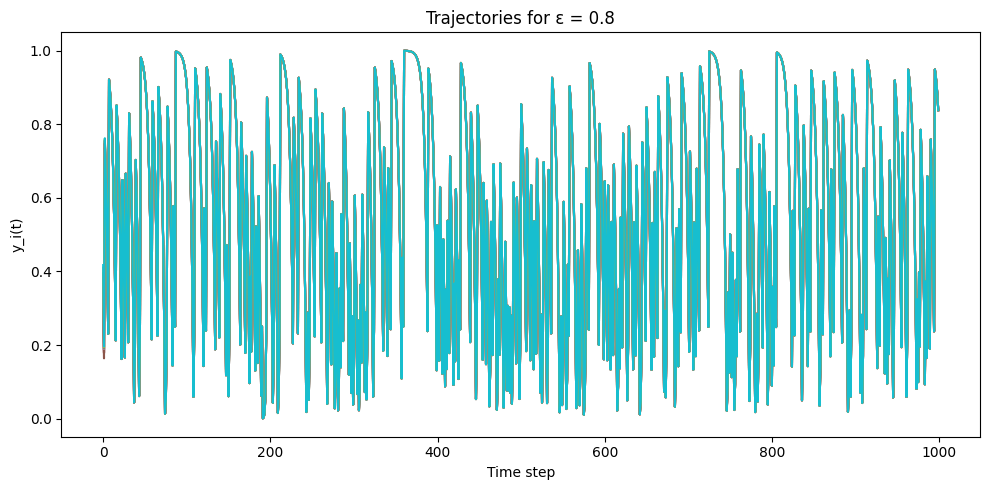

Simulating for ε = 1.0


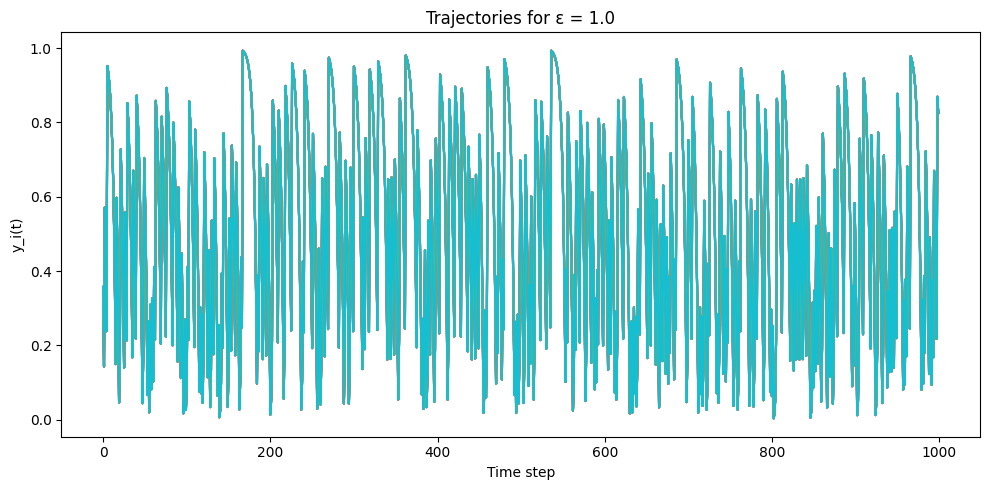

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Skewed Bernoulli map
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

# Simulate system
def simulate_y_trajectories(N=100, T=1000, epsilon=0.3, b=4.0):
    y = np.random.rand(N)
    y_history = np.zeros((T, N))

    for t in range(T):
        y_mean = np.mean(y)
        input_y = (1 - epsilon) * y + epsilon * y_mean
        y = f_SB(input_y, b)
        y_history[t] = y

    return y_history

# Plot line trajectories of selected oscillators
def plot_y_trajectories_lines(y_history, epsilon, num_to_plot=10):
    T, N = y_history.shape
    indices = np.linspace(0, N-1, num_to_plot, dtype=int)

    plt.figure(figsize=(10, 5))
    for i in indices:
        plt.plot(range(T), y_history[:, i], label=f'Osc {i}')
    plt.xlabel("Time step")
    plt.ylabel("y_i(t)")
    plt.title(f'Trajectories for ε = {epsilon}')
    plt.tight_layout()
    plt.show()

# Run for multiple ε values
def run_multiple_epsilon_plots(epsilon_values, N=100, T=1000, b=4.0, num_to_plot=10):
    for epsilon in epsilon_values:
        print(f"Simulating for ε = {epsilon}")
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=epsilon, b=b)
        plot_y_trajectories_lines(y_hist, epsilon, num_to_plot=num_to_plot)

# Define ε values to try based on your λ∞ and γ observations
epsilon_values = [0.02, 0.08, 0.15, 0.25, 0.4, 0.6, 0.8, 1.0]

# Run all
run_multiple_epsilon_plots(epsilon_values)


Simulating for ε = 0.4


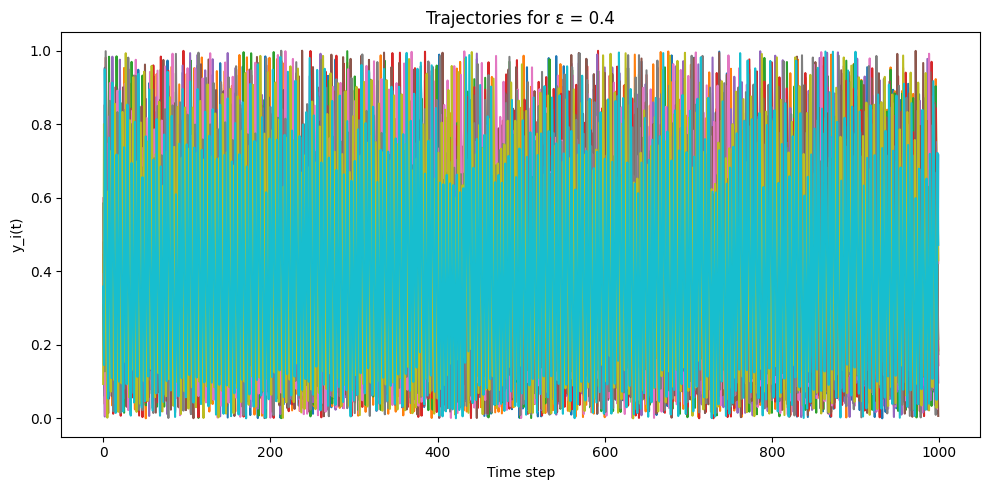

Simulating for ε = 0.41333333333333333


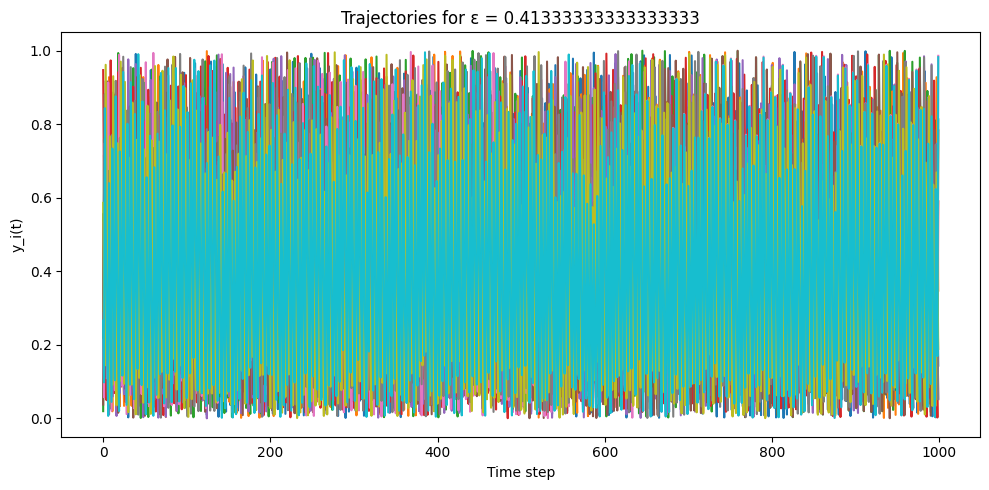

Simulating for ε = 0.4266666666666667


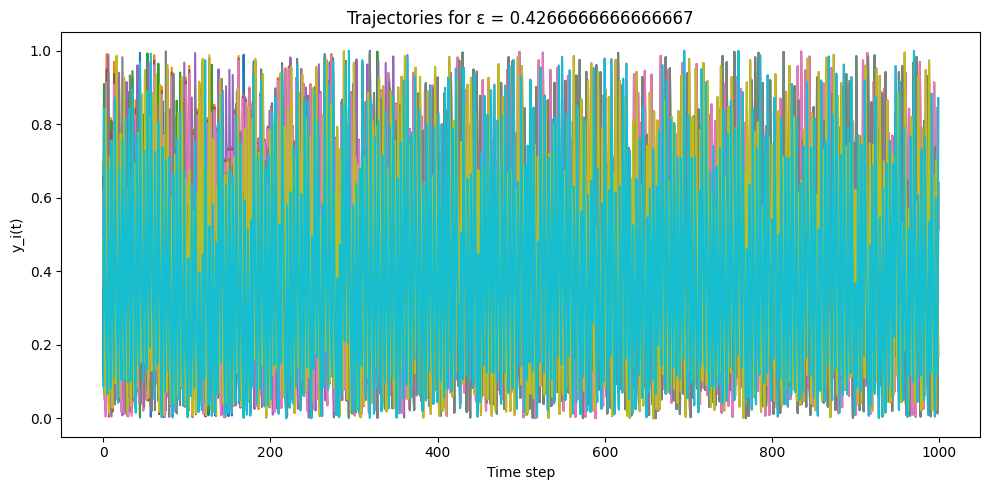

Simulating for ε = 0.44


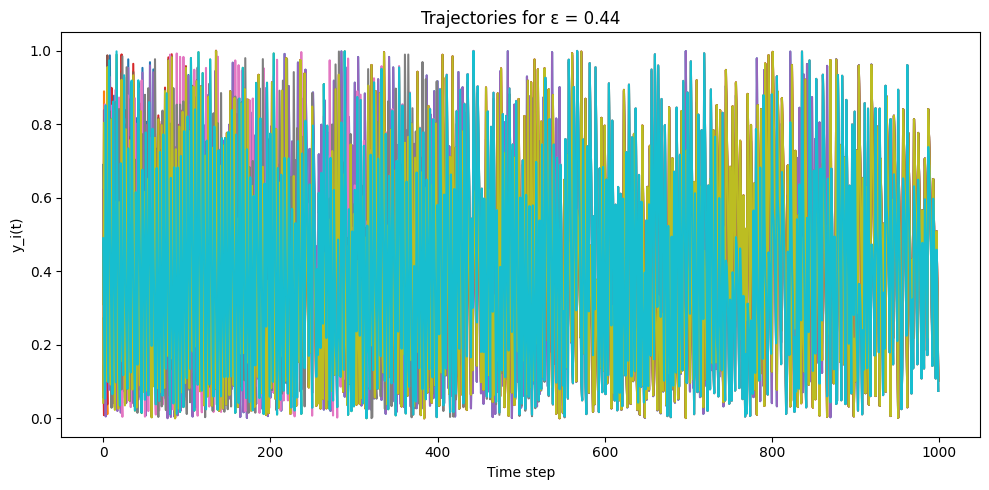

Simulating for ε = 0.45333333333333337


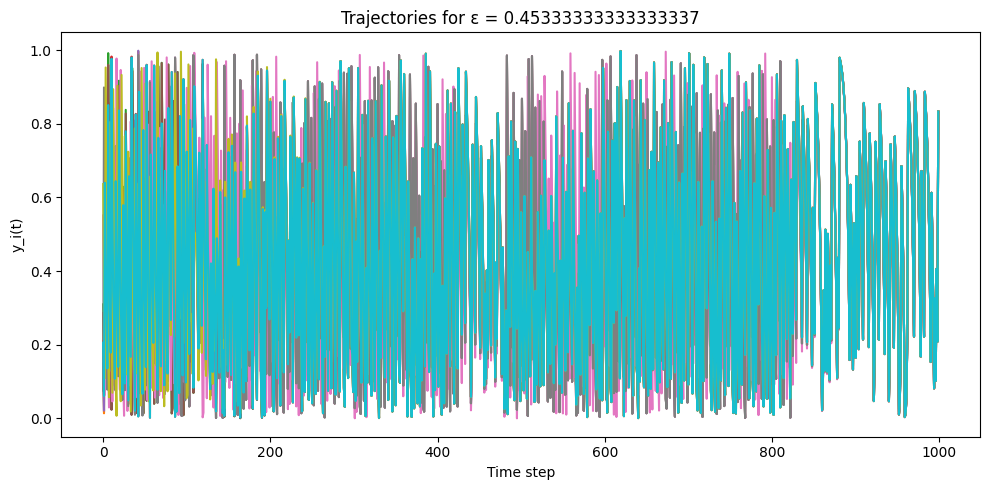

Simulating for ε = 0.4666666666666667


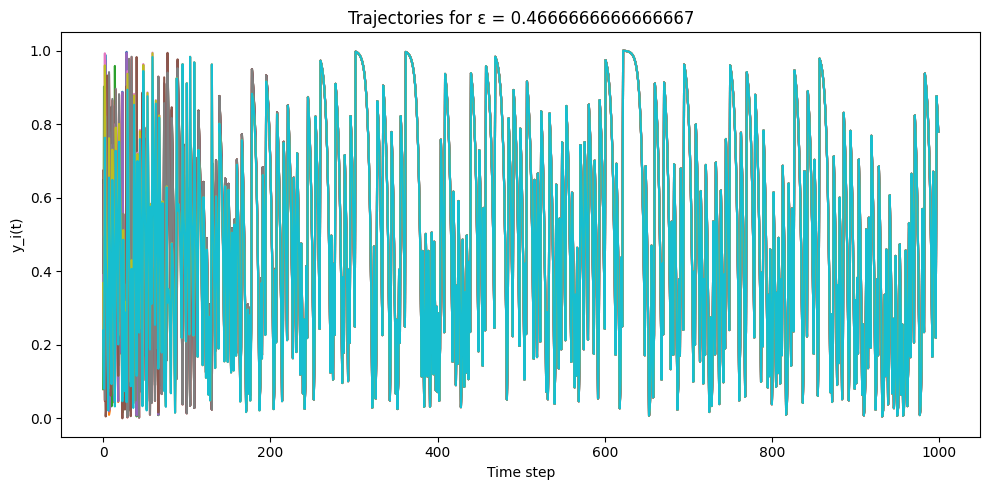

Simulating for ε = 0.48


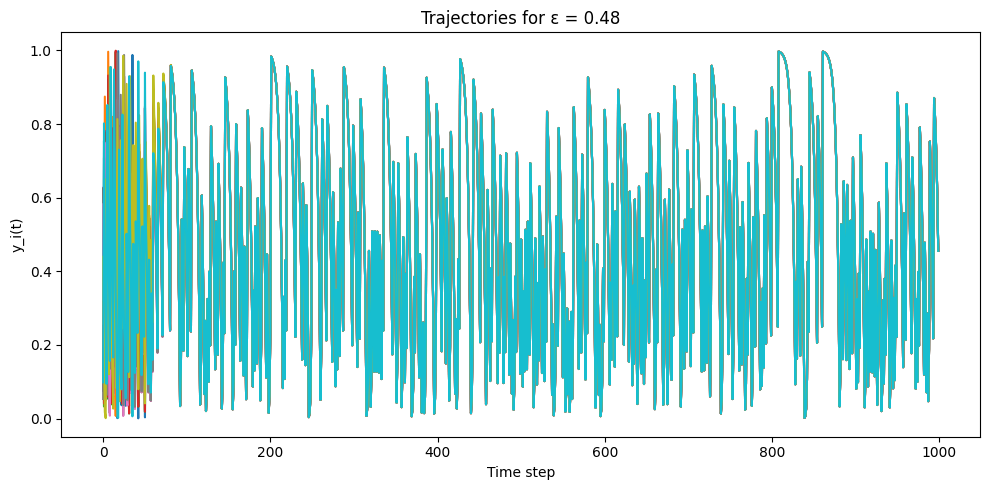

Simulating for ε = 0.49333333333333335


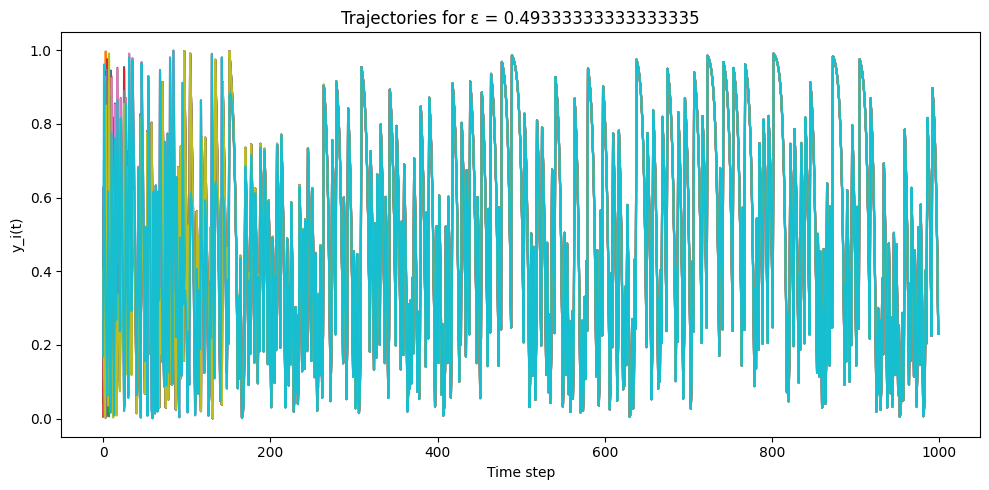

Simulating for ε = 0.5066666666666667


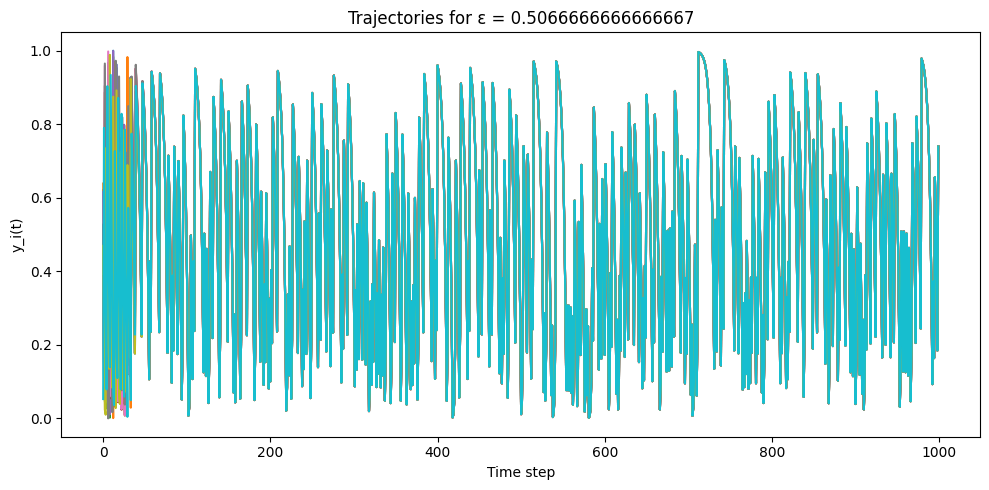

Simulating for ε = 0.52


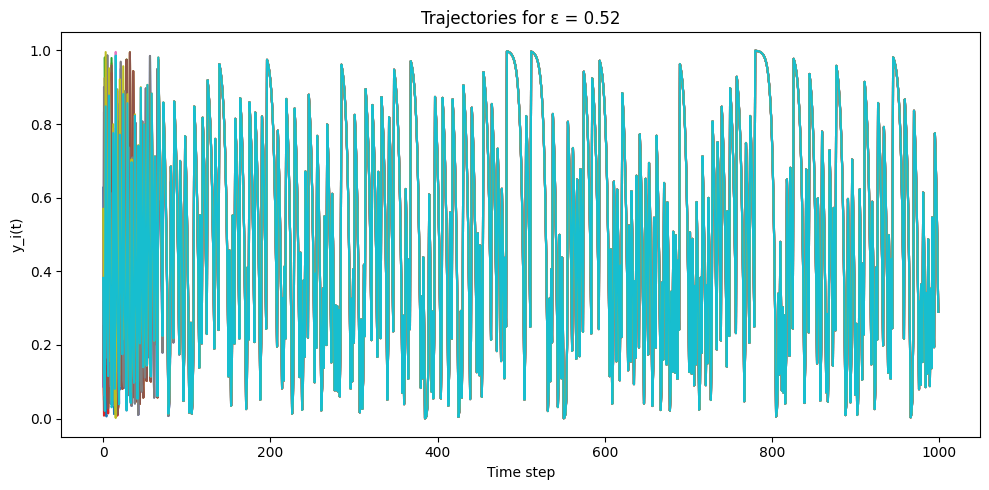

Simulating for ε = 0.5333333333333333


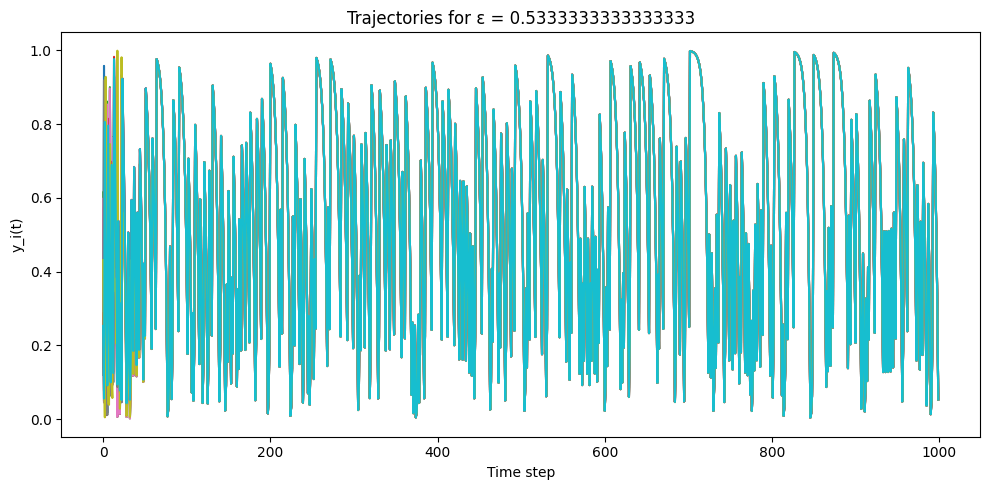

Simulating for ε = 0.5466666666666666


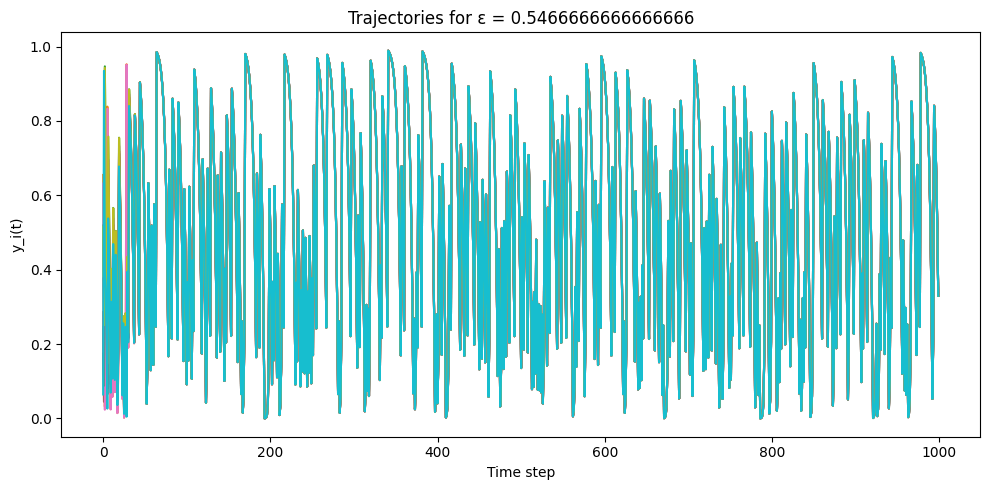

Simulating for ε = 0.56


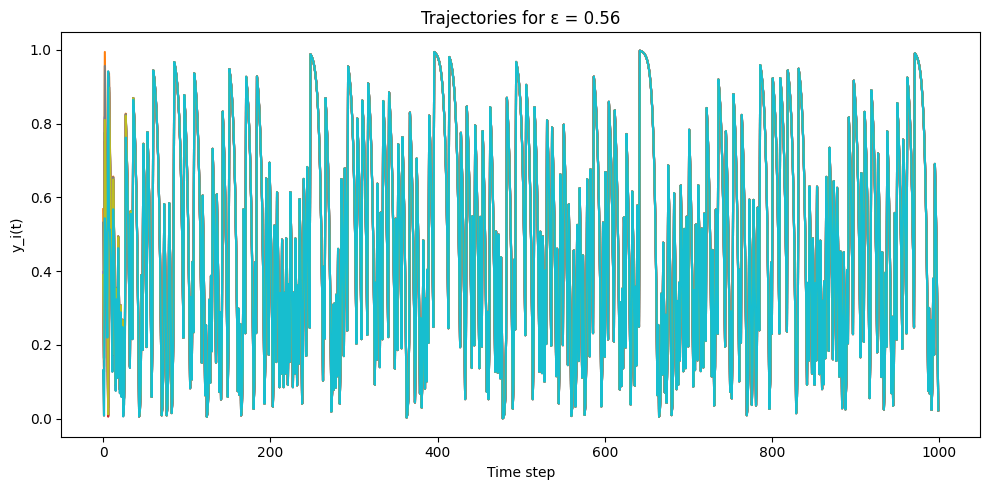

Simulating for ε = 0.5733333333333334


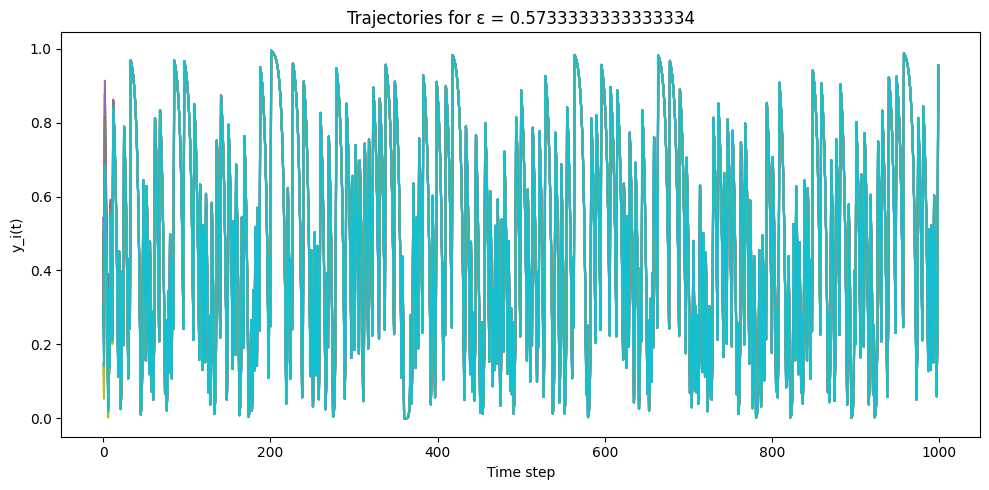

Simulating for ε = 0.5866666666666667


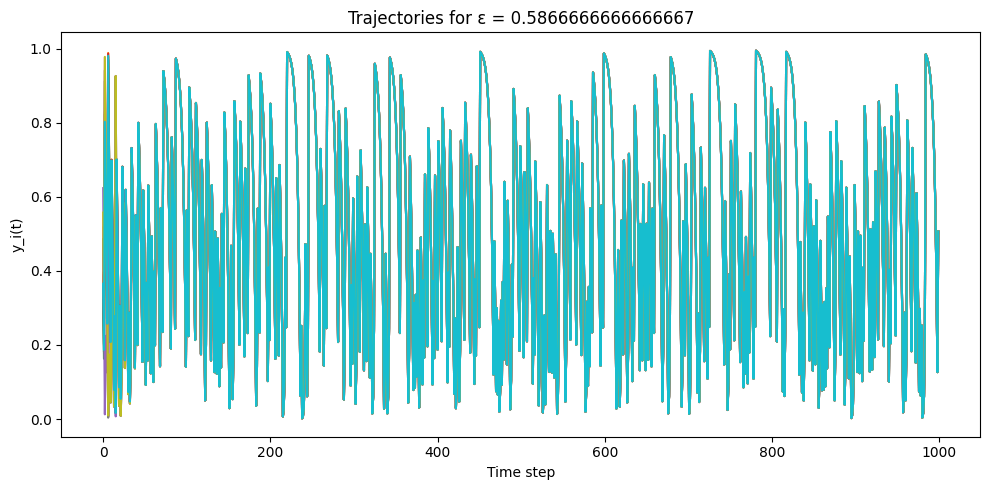

Simulating for ε = 0.6


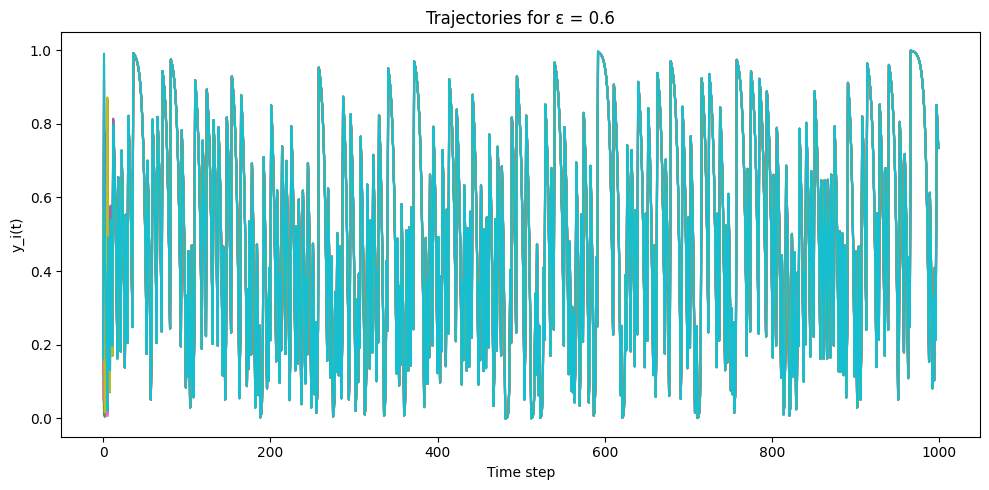

In [ ]:
epsilon_values_zoom = np.linspace(0.4, 0.6, 16)  # ε = 0.40, 0.42, ..., 0.60
run_multiple_epsilon_plots(epsilon_values_zoom, N=100, T=1000, num_to_plot=10)